In [27]:
import sys
sys.path.append("/home/jovyan/FIR/mapillary_sls")

In [28]:
import torch
from sklearn.metrics.pairwise import cosine_similarity
import os
import pandas as pd
import numpy as np
import json
from sklearn.metrics.pairwise import manhattan_distances
# from mapillary_sls.utils import eval
from mapillary_sls.datasets.msls import MSLS
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

In [29]:
def fusion(global_features,local_features):
    """when you apply just the sequeeze() it removes all the ones
    #so (1,2048,1,1) after squeezing -> (2048), adding that extra dimension on the zero 
    #axis :- unsqueeze(0) (1,2048)"""
    

    if global_features.shape[0]==1:
        # x = torch.cat([local_features,global_features],axis=1).squeeze().unsqueeze(0)
        
        x = np.multiply(local_features,global_features).squeeze().unsqueeze(0)

    else: #if we have batch size!=1, then we dont have to unsqueeze because it wont squeeze the batch size       
        # x = torch.cat([local_features,global_features],axis=1).squeeze()
        
        #hardaman product
        x = np.multiply(local_features,global_features).squeeze()

    return x


In [31]:

def orthogonal_fusion(global_matrix,local_matrix):
    global_norm = torch.norm(global_matrix,p=2,dim=1)
    projection = torch.mm(global_matrix,local_matrix.T)
    projection = projection/(global_norm*global_norm)
    orthogonal_comp = local_matrix-projection
    fusion = torch.cat([global_matrix,orthogonal_comp],dim=1)
    # global_feat.expand(orthogonal_comp.size()), orthogonal_comp
    return fusion

In [4]:
global_matrix = torch.randn(1,2048)
local_matrix = torch.randn(1,2048)

In [5]:
print(orthogonal_fusion(global_matrix,local_matrix).size())

torch.Size([1, 4096])


In [ ]:
a= fusion(global_matrix,local_matrix)
b= fusion(global_matrix,local_matrix)

In [32]:
df = pd.read_csv("FIR/advanced_ir/data.csv")

In [ ]:
manhattan_distances(b,a).shape

first CPH length: 6595 second
SF length: 4525

In [33]:
def rank(local_features_cph_query,global_features_cph_query,
         local_features_sf_query,global_features_sf_query,
         local_features_cph_database,global_features_cph_database,
         local_features_sf_database,global_features_sf_database,df):
    
    CPH_LEN = 6595
    SF_LEN = 4525
    for row in range(df.shape[0]):    

        if row<CPH_LEN:
            #unsqueezing because when we access it we result in ([2048]), to make it ([1,2048])
            #same for global
            local_feature_query = local_features_cph_query[row].unsqueeze(0)
            global_feature_query = global_features_cph_query[row].unsqueeze(0)
            
            #applying the fusion (1,4096)
            # query_fusion = fusion(global_feature_query,local_feature_query)
            query_fusion = orthogonal_fusion(global_feature_query,local_feature_query)
            #eval basically converts to the required datatype given the string format

            retrieved_indices = eval(df.iloc[row]["retrieved_indicies"])
            retrieved_ids =  eval(df.iloc[row]["retrieved_ids"])
            
            idx_id = {i:j for i,j in zip(retrieved_indices,retrieved_ids)}
     
            database_feature_list = None
            #fetching all the features first and concatenating them
            for database_id in retrieved_indices:
                #same reason as above(to why we unsqueezing)
                global_feature_database = global_features_cph_database[database_id].unsqueeze(0)
                
                local_feature_database = local_features_cph_database[database_id].unsqueeze(0)
                #(1,4096)
                # combined_features = fusion(global_feature_database,local_feature_database)
                combined_features = orthogonal_fusion(global_feature_database,local_feature_database)
                if database_feature_list is None:
                    database_feature_list = combined_features
                else:
                    database_feature_list = torch.cat([database_feature_list,combined_features])
            #so now we result the size of database_feature_list as -> (top_k,4096)
            #computing the similarity so we get (1,top_k) size. 1 because, 1 query image passed in
            # similarity = cosine_similarity(query_fusion,database_feature_list)
            similarity =  manhattan_distances(query_fusion,database_feature_list)
            #getting the indices of the most similar and mapping to the retrieved list
            ranked_indices = [retrieved_indices[i] for i in np.argsort(similarity)[0]]

            retrieved_file_names = [idx_id[i] for i in ranked_indices]

            df.loc[row,"re_ranked"] = str(ranked_indices)
            df.loc[row,"re_ranked_ids"] = str(retrieved_file_names)

        else: #For SF
            
            row = abs(row-CPH_LEN) 
            
            local_feature_query = local_features_sf_query[row].unsqueeze(0)
            global_feature_query = global_features_sf_query[row].unsqueeze(0)

            # query_fusion = fusion(global_feature_query,local_feature_query)
            query_fusion = orthogonal_fusion(global_feature_query,local_feature_query)
            retrieved_indices = eval(df.iloc[CPH_LEN+row]["retrieved_indicies"])
            
            retrieved_ids =  eval(df.iloc[CPH_LEN+row]["retrieved_ids"])
            
            idx_id = {i:j for i,j in zip(retrieved_indices,retrieved_ids)}

            
            database_feature_list = None
            
            for database_id in retrieved_indices:
          
                global_feature_database = global_features_sf_database[database_id].unsqueeze(0)
                
                local_feature_database = local_features_sf_database[database_id].unsqueeze(0)
                # combined_features = fusion(global_feature_database,local_feature_database)
                combined_features = orthogonal_fusion(global_feature_database,local_feature_database)

                if database_feature_list is None:
                    database_feature_list = combined_features
                else:
                    database_feature_list = torch.cat([database_feature_list,combined_features])
            
            # similarity = cosine_similarity(query_fusion,database_feature_list)
            similarity =  manhattan_distances(query_fusion,database_feature_list)
            ranked_indices = [retrieved_indices[i] for i in np.argsort(similarity)[0]]
            
            retrieved_file_names = [idx_id[i] for i in ranked_indices]
            
            df.loc[CPH_LEN+row,"re_ranked"] = str(ranked_indices)
            df.loc[CPH_LEN+row,"re_ranked_ids"] = str(retrieved_file_names)
    
    return df

In [34]:
DATA_ROOT = "FIR"
DIR_ADVANCED_IR = os.path.join(DATA_ROOT, "advanced_ir") #i added the local features into a folder 'weights' in advanced_ir
DATASET_ROOT = os.path.join(DATA_ROOT, "msls")
DATASET_TEST = os.path.join(DATASET_ROOT, "test")
DATASET_VAL = os.path.join(DATASET_ROOT, "train_val")
DATASET_VAL_SF = os.path.join(DATASET_VAL, "sf")
DATASET_VAL_CPH = os.path.join(DATASET_VAL, "cph")

In [35]:
local_features_cph_query = torch.from_numpy(np.load(os.path.join(DIR_ADVANCED_IR,"weights/MSLS_resnext_GCL_multi_attrous_attention_map_cph_local_queryfeats.npy")))
global_features_cph_query =  torch.from_numpy(np.load(os.path.join(DATA_ROOT,"results/MSLS/val/MSLS_resnext_GeM_480_GCL_cph_queryfeats.npy")))

local_features_sf_query =  torch.from_numpy(np.load(os.path.join(DIR_ADVANCED_IR,"weights/MSLS_resnext_GCL_multi_attrous_attention_map_sf_local_queryfeats.npy")))
global_features_sf_query =  torch.from_numpy(np.load(os.path.join(DATA_ROOT,"results/MSLS/val/MSLS_resnext_GeM_480_GCL_sf_queryfeats.npy")))

local_features_cph_database =  torch.from_numpy(np.load(os.path.join(DIR_ADVANCED_IR,"weights/MSLS_resnext_GCL_multi_attrous_attention_map_cph_local_mapfeats.npy")))
global_features_cph_database =  torch.from_numpy(np.load(os.path.join(DATA_ROOT,"results/MSLS/val/MSLS_resnext_GeM_480_GCL_cph_mapfeats.npy")))

local_features_sf_database =  torch.from_numpy(np.load(os.path.join(DIR_ADVANCED_IR,"weights/MSLS_resnext_GCL_multi_attrous_attention_map_sf_local_mapfeats.npy")))
global_features_sf_database =  torch.from_numpy(np.load(os.path.join(DATA_ROOT,"results/MSLS/val/MSLS_resnext_GeM_480_GCL_sf_mapfeats.npy")))

In [ ]:
# #simulation 


# local_features_cph_query = torch.randn(6595,2048)
# global_features_cph_query = torch.randn(6595,2048)

# local_features_sf_query = torch.randn(4525,2048)
# global_features_sf_query = torch.randn(4525,2048)

# local_features_cph_database = torch.randn(20000,2048)
# global_features_cph_database = torch.randn(20000,2048)

# local_features_sf_database = torch.randn(20000,2048)
# global_features_sf_database = torch.randn(20000,2048)

In [ ]:
eval("[1,2,3,4]")

In [36]:
new_df = rank(local_features_cph_query, global_features_cph_query,
     local_features_sf_query,global_features_sf_query,
     local_features_cph_database,global_features_cph_database,
     local_features_sf_database,global_features_sf_database,df)

In [16]:
new_df.head()



,Unnamed: 0,query_id,retrieved_ids,retrieved_indicies,re_ranked,re_ranked_ids
0,0,x3vA7Bk0HNI6rGkDpDZQUQ,"['X9V1oGRaAEFjq5jufrklTQ', 'E7gcrCyitkguCnMzoE...","[3, 5130, 5131, 0, 7912, 5132, 8812, 9186, 1, ...","[3, 0, 5130, 5131, 8812, 1, 7912, 4505, 5132, ...","['X9V1oGRaAEFjq5jufrklTQ', 'm6_LAhWivjGN4O1fkW..."
1,1,U9Vj0IV4q1psciXpj51F_w,"['X9V1oGRaAEFjq5jufrklTQ', '22BOHMokEHyXf9LA8B...","[3, 4504, 1, 1815, 9186, 0, 2, 9181, 5131, 513...","[1, 3, 4504, 9183, 9181, 9182, 9184, 2, 1815, ...","['HU9GEfLAB9pm5RmjW4MLhg', 'X9V1oGRaAEFjq5jufr..."
2,2,Eh1NwQjH4jbKcWqVJ4ZsJg,"['X9V1oGRaAEFjq5jufrklTQ', '_Eq8EgtwLGiMFc7VJd...","[3, 4, 2, 1815, 7604, 1, 0, 8810, 5, 9186, 6, ...","[3, 2, 4, 1, 0, 8810, 5, 6, 7604, 8809, 5133, ...","['X9V1oGRaAEFjq5jufrklTQ', 'qhZA-uC4KY1F38C_Hb..."
3,3,1RKCGBAWsZbi5dj3vR2mlw,"['_Eq8EgtwLGiMFc7VJdb-YQ', 'X9V1oGRaAEFjq5jufr...","[4, 3, 5, 6, 0, 8815, 9186, 9181, 8798, 1, 513...","[4, 3, 5, 6, 9181, 0, 1, 12219, 8815, 8810, 91...","['_Eq8EgtwLGiMFc7VJdb-YQ', 'X9V1oGRaAEFjq5jufr..."
4,4,LdiYwYkqgUfc1IYDu5ov9A,"['Z4MR4AHQufgsCwiBiqQ23A', 'eQ-8kVNfMZiexVcu_V...","[5, 6, 4, 8815, 5133, 7049, 5125, 8816, 8811, ...","[5, 6, 4, 3, 5133, 12219, 8816, 8815, 34, 1192...","['Z4MR4AHQufgsCwiBiqQ23A', 'eQ-8kVNfMZiexVcu_V..."


In [ ]:
df.head()

python mapillary_sls/evaluate.py --prediction "predictions.txt" --msls-root "msls/" --cities "cph,sf"

In [74]:


#     results+=" "+ df.iloc[i]["query_id"] + " " +  " ".join([str(i) for i in eval(df.iloc[i]["re_ranked_ids"])[:4]])
#     results+="\n"


with open('FIR/predictions.txt', 'w') as f:
    for i in range(df.shape[0]):
        results=df.iloc[i]["query_id"] + " " +  " ".join([str(i) for i in eval(df.iloc[i]["re_ranked_ids"])]) +"\n"
        f.write(results)

<h3>New plot function image</h3>

In [240]:
def plot_image(index,df,top_k):
    index = index
    top_k = top_k
    CPH_LEN = 6595
    SF_LEN = 4525

    with open(os.path.join(DATASET_VAL_CPH, "query.json"), "r") as f:
        # load the query json file
        query_cph = json.load(f)['im_paths']
        # cph length
        cph_len = len(query_cph)

    # read the query json file for sf
    with open(os.path.join(DATASET_VAL_SF, "query.json"), "r") as f:
        # load the query json file
        query_sf = json.load(f)['im_paths']
        # sf length
        sf_len = len(query_sf)

    with open(os.path.join(DATASET_VAL_CPH, "database.json"), "r") as f:
    # load the database json file
        database_cph = json.load(f)['im_paths']
        # cph length
        cph_len = len(query_cph)
    with open(os.path.join(DATASET_VAL_SF, "database.json"), "r") as f:
    # load the database json file
        database_sf = json.load(f)['im_paths']
        # cph length
        sf_len = len(database_sf)


    files = []
    query = DATASET_ROOT + "/" + query_cph[index] if index<=CPH_LEN else DATASET_ROOT + "/" + query_sf[abs(index-cph_len)]


    for k in range(top_k):

        for ranked_indices in eval(df.loc[index,"re_ranked"]):
            if index<=CPH_LEN:
                files.append(DATASET_ROOT + "/" +  database_cph[ranked_indices])
            else:
                files.append(DATASET_ROOT + "/" + database_sf[ranked_indices])
            # else:

    files_retrieved_indices = []

    for k in range(top_k):
        for retrieved_indices in eval(df.loc[index,"retrieved_indicies"]):
            # print(retrieved_indices)
            if index<=CPH_LEN:
                files_retrieved_indices.append(DATASET_ROOT + "/" +  database_cph[retrieved_indices])
            else:
                files_retrieved_indices.append(DATASET_ROOT + "/" + database_sf[retrieved_indices])

        
    if top_k<=5:
        fig,axs = plt.subplots(3,top_k,figsize=(10, 5))


        for row_ix,col in enumerate(axs):
            for column_ix,col_value in enumerate(col):
                # index = column_ix-1 if column_ix!=0 else 0
                col_value.set_xticklabels([])
                col_value.get_xaxis().set_visible(False)
                col_value.get_yaxis().set_visible(False)
                col_value.set_yticklabels([])
               
                if column_ix==0 and row_ix==0:
                    image = plt.imread(query)
                    col_value.imshow(image)
                    col_value.title.set_text("Query")

                else:
                    if row_ix==0 and column_ix>0: #remove all the unwanted axis in the query
                        col_value.set_axis_off()

                    if row_ix==1:
                        if column_ix==0:
                            col_value.title.set_text("Fusion")
                            image = plt.imread(files[column_ix])
                            col_value.imshow(image)
                        else:

                            image = plt.imread(files[column_ix])
                            col_value.imshow(image)
                    if row_ix==2:
                        if column_ix==0:
                            col_value.title.set_text("GCL features")
                            image = plt.imread(files_retrieved_indices[column_ix])
                            col_value.imshow(image)
                        else:
                            image = plt.imread(files_retrieved_indices[column_ix])
                            col_value.imshow(image)    
                            
    else:
        fig,axs = plt.subplots((top_k)+1,2,figsize=(10, 30))
        for row_ix,col in enumerate(axs):
            index = row_ix-1 
            for column_ix,col_value in enumerate(col):

                col_value.set_xticklabels([])
                col_value.get_xaxis().set_visible(False)
                col_value.get_yaxis().set_visible(False)
                col_value.set_yticklabels([])

                if row_ix==0 and column_ix==0:
                    image = plt.imread(query)
                    col_value.imshow(image)
                    col_value.title.set_text("Query")

                else:
                    if row_ix==0 and column_ix>0: #remove all the unwanted axis in the query
                        col_value.set_visible(False)
                    if row_ix==1 and column_ix==0:
                        col_value.title.set_text("Fusion Method")
                        image = plt.imread(files[index])
                        col_value.imshow(image)    
                    if row_ix==1 and column_ix==1:
                        col_value.title.set_text("GCL Method")
                        image = plt.imread(files_retrieved_indices[index])
                        col_value.imshow(image)    
                    if row_ix>1 and column_ix==0:
                        col_value.title.set_text(f"Index : {index}")
                        image = plt.imread(files[index])
                        col_value.imshow(image)    

                    if row_ix>1 and column_ix==1:
                        image = plt.imread(files_retrieved_indices[index])
                        col_value.imshow(image)    

    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])

    plt.show()
    plt.axis('off')


<h3>For plotting top 5</h3>

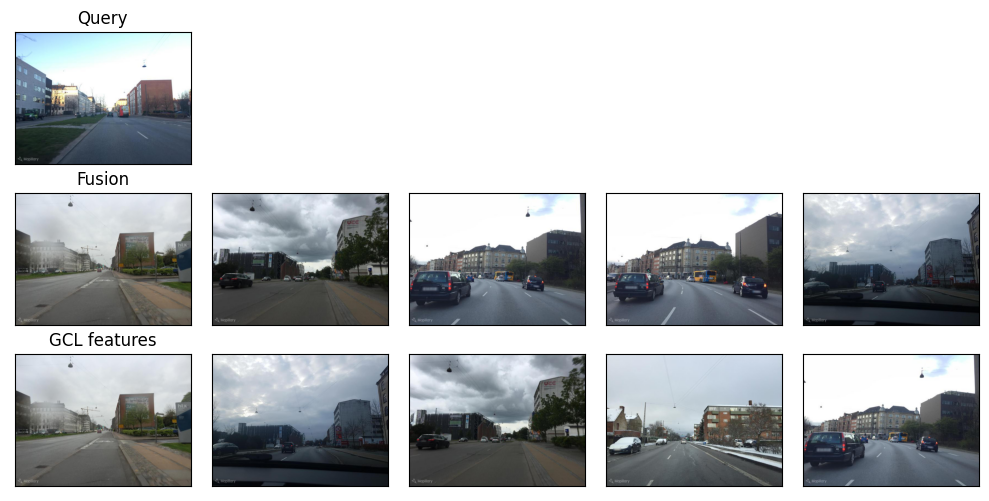

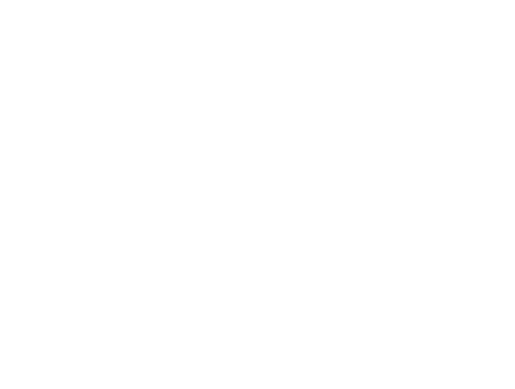

In [229]:

plot_image(20,df,5)

<h3>Made it double for easy inspection</h3>

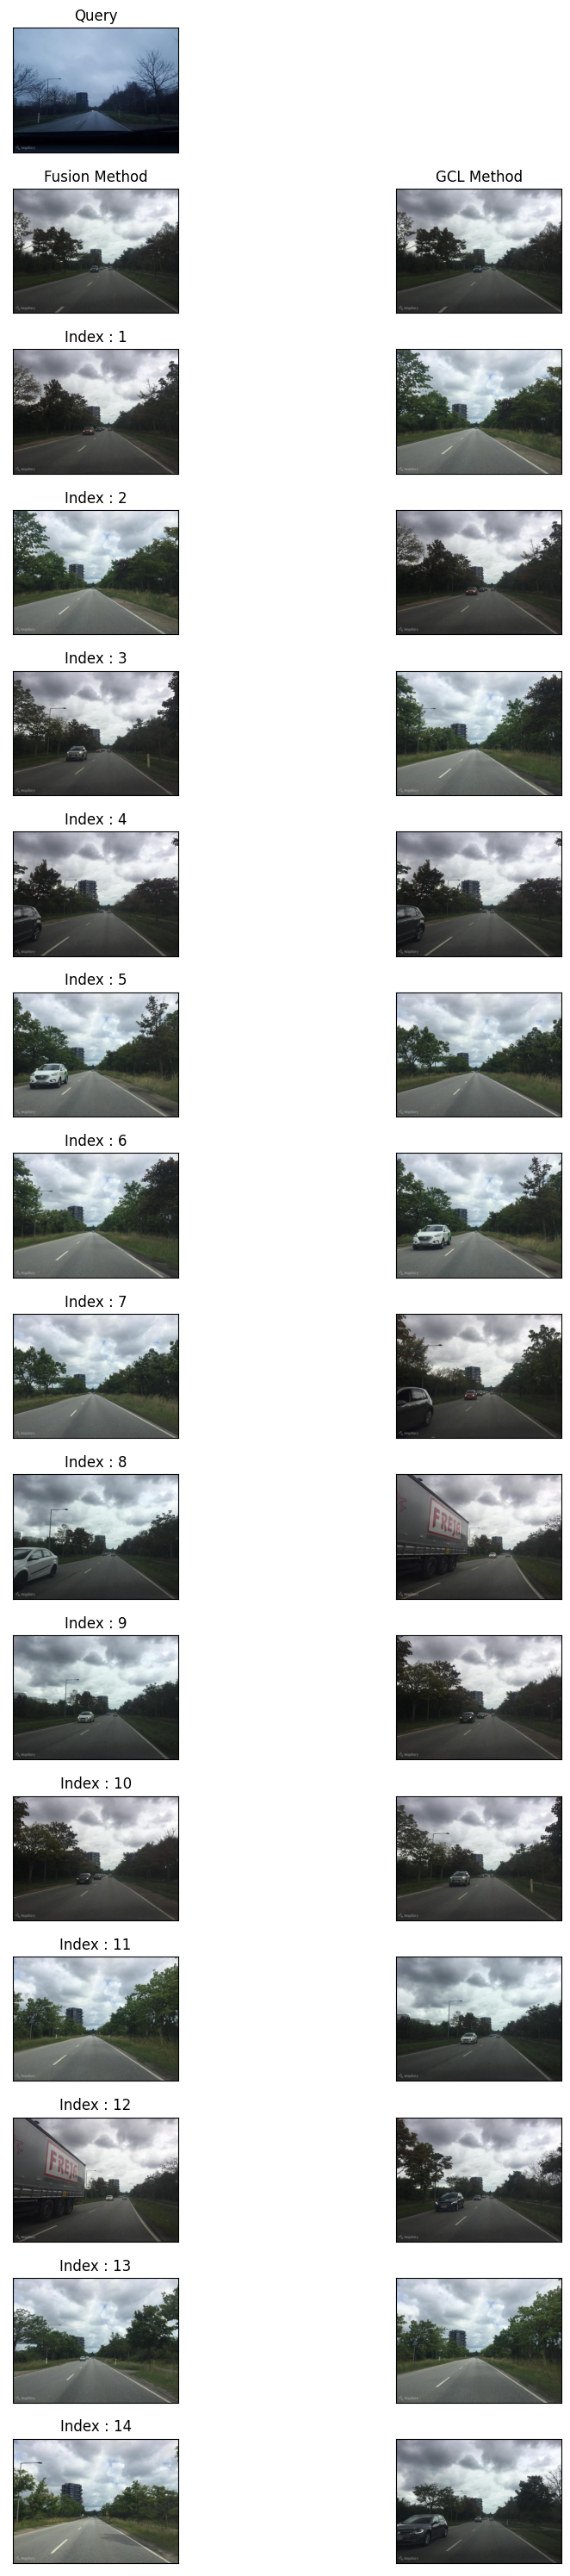

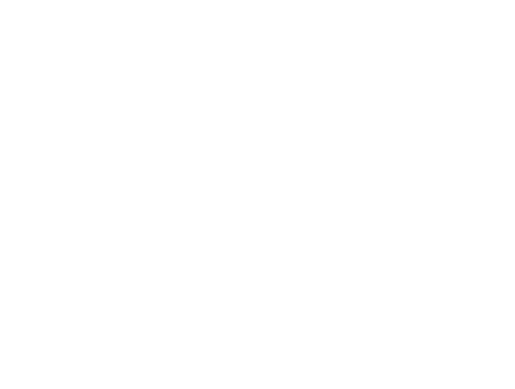

In [241]:
plot_image(300,df,15)

In [ ]:
def plot_image(index,df,top_k):
    index = index
    top_k = top_k
    CPH_LEN = 6595
    SF_LEN = 4525


    with open(os.path.join(DATASET_VAL_CPH, "query.json"), "r") as f:
        # load the query json file
        query_cph = json.load(f)['im_paths']
        # cph length
        cph_len = len(query_cph)

    # read the query json file for sf
    with open(os.path.join(DATASET_VAL_SF, "query.json"), "r") as f:
        # load the query json file
        query_sf = json.load(f)['im_paths']
        # sf length
        sf_len = len(query_sf)

    with open(os.path.join(DATASET_VAL_CPH, "database.json"), "r") as f:
    # load the database json file
        database_cph = json.load(f)['im_paths']
        # cph length
        cph_len = len(query_cph)
    with open(os.path.join(DATASET_VAL_SF, "database.json"), "r") as f:
    # load the database json file
        database_sf = json.load(f)['im_paths']
        # cph length
        sf_len = len(database_sf)


    files = []
    query = DATASET_ROOT + "/" + query_cph[index] if index<=CPH_LEN else DATASET_ROOT + "/" + query_sf[abs(index-cph_len)]


    for k in range(top_k):

        for ranked_indices in eval(df.loc[index,"re_ranked"]):
            if index<=CPH_LEN:
                files.append(DATASET_ROOT + "/" +  database_cph[ranked_indices])
            else:
                files.append(DATASET_ROOT + "/" + database_sf[ranked_indices])
            # else:

    files_retrieved_indices = []
    # retrieved_indices = eval(df.iloc[index,"retrieved_indices"])

    # print(retrieved

    for k in range(top_k):
        for retrieved_indices in eval(df.loc[index,"retrieved_indicies"]):
            # print(retrieved_indices)
            if index<=CPH_LEN:
                files_retrieved_indices.append(DATASET_ROOT + "/" +  database_cph[retrieved_indices])
            else:
                files_retrieved_indices.append(DATASET_ROOT + "/" + database_sf[retrieved_indices])


    fig,axs = plt.subplots(1,top_k+1,figsize=(20, 20))


    for index,ax in enumerate(axs):
        if index==0: 
            image = plt.imread(query)
            ax.imshow(image)
            ax.title.set_text(f'Query')
        else:
            image = plt.imread(files[index-1])
            ax.imshow(image)

        ax.set_xticks([])
        ax.set_yticks([])

    fig,new_axs = plt.subplots(1,top_k+1,figsize=(20, 20))


    for index,ax in enumerate(new_axs):
        image = plt.imread(files_retrieved_indices[index])
        ax.imshow(image)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()
    print("#########")